In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# The goal for this project was to intensely clean as much of the two datasets given(test and train set), whilst fitting it with multiple models for analysis. Missing data that was cleaned,scaled and imputed. The explanations are done straight to the point with clear and explanatory text.🚢

In [ ]:
#!pip install lazypredict

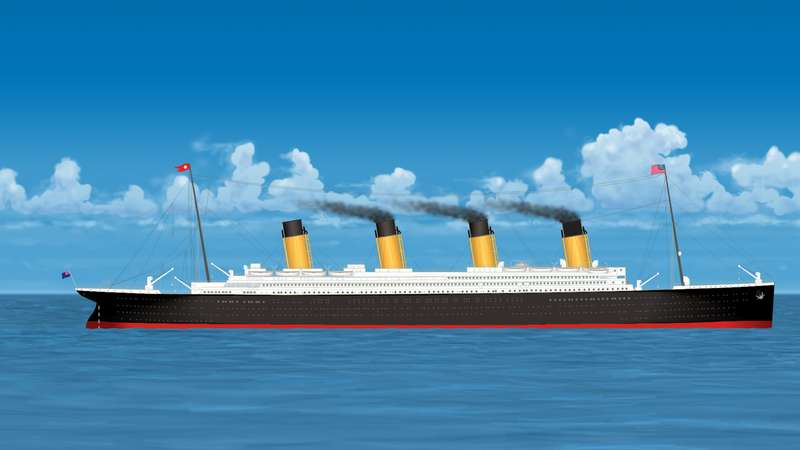

# Import libraries🚢

In [ ]:
# Visualization 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

In [ ]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.info()


In [ ]:
train_data.head()

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

In [ ]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.info()

In [ ]:
test_data.head()

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

# before cleaning, we shall do data exploration 🚢

relationship with categorical variables

We can already see that there is one outlier with person that survived with an overwhelming fare that is around 500.

In [ ]:
data = pd.concat([train_data['Survived'], train_data['Fare']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train_data['Survived'], y=train_data['Fare'], data=data)
#fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

its true to say and confirms that there is one extreme outlier that needs to be fixed.

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(train_data['Survived'],train_data['Fare'])
ax.set_xlabel('Survived')
ax.set_ylabel('Fare')
plt.show()

# Outlier detected as fare > 500 🚢
both test and train data have fare outliers

In [ ]:
train_data[train_data['Fare'] > 500]

In [ ]:
test_data[test_data['Fare'] > 500]

this will make it easier if all the fares that are 512.3292 are replaced by 7.25 and removed. 

In [ ]:
#do it for both sets
train_data["Fare"].replace({ 512.3292 : 7.25}, inplace=True)
test_data["Fare"].replace({ 512.3292 : 7.25}, inplace=True)

check if the passengers 259, 680, 738	and test data passenger 1235 are all nans in their fares and remove them

In [ ]:
train_data = train_data[(train_data.PassengerId != 259) & (train_data.PassengerId != 680) & (train_data.PassengerId != 738)]

# CLEAN DATA next 🚢
Both train and test both have same columns (except survived as thats the predictor)

In [ ]:
#Check for na's
train_data.isna().sum()


In [ ]:
test_data.isna().sum()

# Use msno to get a sense of what categories are missing from training and test set.NOTE: png's sometimes will be disabled because of competition submitting. 🚢

In [ ]:
import missingno as msno 
msno.bar(train_data) 

As we can see there is an uneven amount of Nans for each data set. 

# train_data = Age, cabin and embarked are important to fix the na's🚢
# test_data = Age, cabin and Fare are important to fix the na's🚢

In [ ]:
#train data has 177 age nans
m = train_data['Age'].mean()
m

In [ ]:
#test data has 86 age nans
m = test_data['Age'].mean()
m

In [ ]:
train_data['Age'] = train_data['Age'].replace(np.nan, 29)
test_data['Age'] = test_data['Age'].replace(np.nan, 30)

In [ ]:
#next is cabin 
#Shows there is more than 60% of NA's for the column so we should drop it. Judging by .info()
train_data = train_data.drop(['Cabin'], axis=1)
test_data = test_data.drop(['Cabin'], axis=1)

In [ ]:
#embarked on train data is only 2 nans
#embarked on test data is 0
train_data['Embarked'] = train_data['Embarked'].replace(np.nan, 'Q')

#Fare on train data is 0 nans
#Fare on test data is 1
#m = test_data['Fare'].mean()
#The mean obtained was 36 for the column 'Fare'
test_data['Fare'] = test_data['Fare'].replace(np.nan, 36.0)

# Lets check again for nan's🚢

In [ ]:
#Check for na's
train_data.isna().sum()

In [ ]:
#Check for na's
test_data.isna().sum()

# feature engineer the 'name' column(not implemented in final, but a good way to learn of anything important)🚢

as its useful, also because we want to keep around the 10 variable mark.

Statistically we want a 1 predictor to 10 ratio (1 to ten)

We will keep the name column - progress this is because if you can group the families, that can help determine if they survive or not.

In [ ]:
# create a new feature to extract title names from the Name column
#We can see that there are alot of extra names we dont need.
train_data['Title'] = train_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
train_data.Title.value_counts()

In [ ]:
test_data['Title'] = test_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
test_data.Title.value_counts()

Furthermore we can map it like so to.. reduce the number of categories of names.

# thanks to https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9 for the extra help on the normalization of the name column.🚢

We know that the obvious names such as Mr,Miss,Mrs etc. can be their own categories.

In [ ]:
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royal",
    "Don":        "Royal",
    "Sir" :       "Royal",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royal",
    "Dona":       "Royal",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royal"
}
# map the normalized titles to the current titles for train and test data.
train_data.Title = train_data.Title.map(normalized_titles)
test_data.Title = test_data.Title.map(normalized_titles)

We can see below that the outlier names are all gone now.

In [ ]:
# view value counts for the normalized titles
test_data.Title.value_counts()

In [ ]:
# view value counts for the normalized titles
train_data.Title.value_counts()

# ENCODE CATEGORICAL VARIABLES🚢
sex, ticket and embarked and name.

# Start off with sex which has either male or female.🚢

Depending on the data we have, we might run into situations where, after label encoding, we might confuse our model into thinking that a column has data with some kind of order or hierarchy, when we clearly don’t have it. To avoid this, we ‘OneHotEncode’ that column. https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In order to one hot encode we must take in the label encode and use it as a parameter.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#initialize label endoce as first step.
le = LabelEncoder()

train_data["Sex"] = le.fit_transform(train_data["Sex"].values)
test_data["Sex"] = le.fit_transform(test_data["Sex"].values)

# Second we focus on ticket🚢
ticket is an interesting one, as its an object with several nuances. Several categories, some with random conjunctions of letters and numbers


ticket type : A/5, PC, etc. Not every ticket has associated type
ticket number: starting from 0 to 3101317. 
For most of the tickets first number is associated with Pclass, except tickets that are less than 5 digits long or tickets than have ticket type associated with them. There is not much additional information in ticket number, so it can be ommited

We are not too fussed about the ticket number so we can simply just get the ticket type such as a/5 and PC

In [ ]:
# for now we drop ticket column
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

# Third we focus on embarked🚢
Simply its all categorical objects.

In [ ]:
train_data["Embarked"].value_counts()

In [ ]:
#label encode them 
train_data["Embarked"] = le.fit_transform(train_data["Embarked"].values)
test_data["Embarked"] = le.fit_transform(test_data["Embarked"].values)

# lastly is Name🚢

In [ ]:
train_data["Name"] = le.fit_transform(train_data["Name"].values)
test_data["Name"] = le.fit_transform(test_data["Name"].values)

In [ ]:
train_data.info()

In [ ]:
test_data.info()

In [ ]:
train_data.head()

In [ ]:
test_data.head()

# SCALE after split: next we use a scaler such as min max. Max-Min Normalization will be used as we will obtain smaller standard deviations.🚢

In [ ]:
#With the power of google, many people say logistic regression is the best for titanic datasets.
#although lightgbm is more suited 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as gbm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

In [ ]:
#"PassengerId","Pclass",'Name',"Sex","Age","SibSp","Parch","Fare","Embarked"
#But due to feature importance  Passengerid,Name,Parch,Embarked have been removed

features = ["Pclass","Sex","Age","SibSp","Fare"]
X = train_data[features]
y = train_data['Survived']

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.15)

#Last bit - encode labels
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# MODEL FITTING(with gridsearch) and finding useful variables using FEATURE IMPORTANCE🚢

# random forest(with gridsearch)🚢

In [ ]:
pipelineone = Pipeline([('RandomForest', RandomForestClassifier())])

param_grid = {'RandomForest__max_features': ['auto'],
 'RandomForest__min_samples_leaf': [1, 2, 4],
 'RandomForest__min_samples_split': [2,3,4],
 'RandomForest__n_estimators': [100,200,300]}


#Gridsearch takes in param_grid, and pipeline.
model = GridSearchCV(pipelineone, param_grid, cv =None)
model.fit(X_train, y_train)

#submission
y_pred_sub = model.predict(test_data[features])  

y_pred_random = model.predict(X_test)
forest = accuracy_score(y_test, y_pred_random)
print(forest)

# random forest feature importance🚢

higher means better and more important

"PassengerId","Pclass",'Name',"Sex","Age","SibSp","Parch","Fare","Embarked"

the weakest/less important columns are Passengerid,Name,SibSp,Parch,Embarked. They were removed as a result.

# logistic regression(with gridsearch)🚢

In [ ]:
#[0.001, 0.01, 0.1, 1, 10, 100, 1000]
pipelinetwo = Pipeline([('logisticregression', LogisticRegression(max_iter=100))])
param_grid = {'logisticregression__penalty' : ['l2'],
              'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__solver' : ['liblinear']}

#Gridsearch takes in param_grid, and pipeline.
model = GridSearchCV(pipelinetwo, param_grid, cv =None)
model.fit(X_train, y_train)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)  
logistic = accuracy_score(y_test, y_pred)
print(logistic)

# logistic regression feature importance🚢

"PassengerId","Pclass",'Name',"Sex","Age","SibSp","Parch","Fare","Embarked"

Large positive values of w_j signify higher importance of the jth feature in the prediction of positive class. Large negative values signify higher importance in the prediction of negative class.

We can see that the less significant columns are "PassengerId", "Name", "Parch","Fare","Embarked"

In [ ]:
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# XGBOOST🚢

In [ ]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)  
XGB = accuracy_score(y_test, y_pred)
print(XGB)

# KNeighborsClassifier🚢

In [ ]:
KN = KNeighborsClassifier(n_neighbors=3)
KN.fit(X_train, y_train)
y_pred = KN.predict(X_test)  
knn = accuracy_score(y_test, y_pred)
print(knn)

# SVC🚢

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)  
SVC = accuracy_score(y_test, y_pred)
print(SVC)

# Linear SVC🚢

In [ ]:
lsvc = LinearSVC(random_state=0)
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)  
LSVC = accuracy_score(y_test, y_pred)
print(LSVC)

In [ ]:
finalleaderboard = {
  "Random Forest": forest,
  "logistic regression": logistic,  
  "XGB": XGB,
  "KNeighborsClassifier": knn,
  "SVC": SVC,
  "Linear SVC": LSVC  
}

finalleaderboard = pd.DataFrame.from_dict(finalleaderboard, orient='index', columns=['Accuracy'])
print(finalleaderboard)

In [ ]:
len(y_pred_random)

In [ ]:

#Code required to submit for competition
#There must be 418  test rows - test_data must be 418
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_pred_sub})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
test_data.PassengerId.shape, y_pred_sub.shape

In [ ]:
print(np.count_nonzero(y_pred))
#conclusion:
#This many survived.

# Extra step: Adding a lazy classifier to better understand other models🚢

https://pypi.org/project/lazypredict/

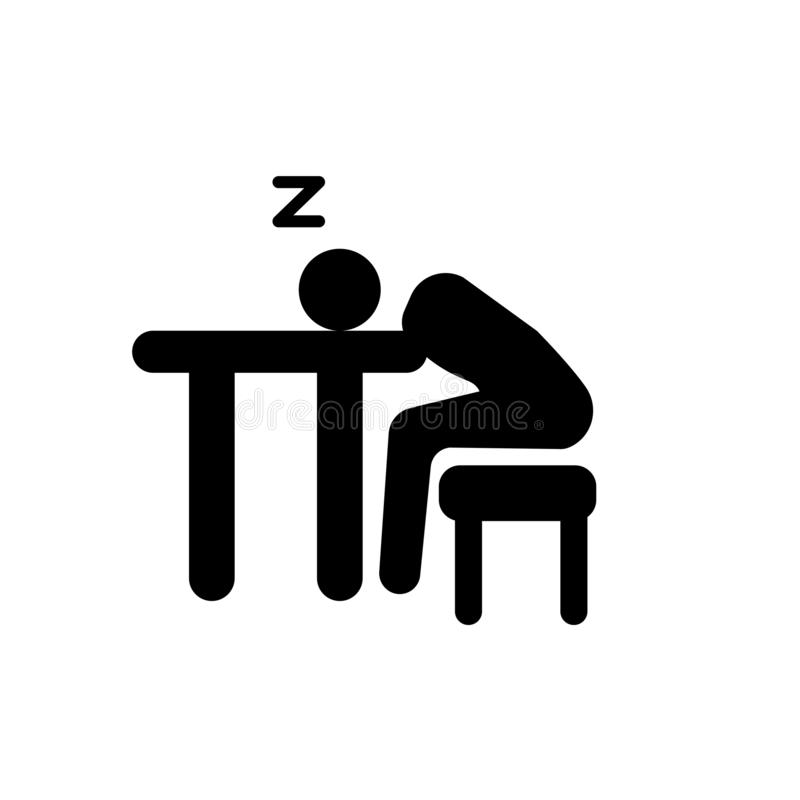

# major lessons learned:🚢

The overall score went down when removing columns, so it was better to impute them with the means of each column to get a higher score. If i did that then the score would skyrocket probably past my highest score ever of 78%.
But it was the right call to disable the rows that had major Nans like above 60% of their columns.

Feature importance narrowed the columns "PassengerId","Pclass",'Name',"Sex","Age","SibSp","Parch","Fare","Embarked" down to just ["Pclass","Sex","Age","SibSp","Fare"]. This was because the other columns were removed due to their smaller significance in each model. This was done through the random forest and logistic regression feature importance code.

Regression analysis wise, there was a huge KNeighborsClassifier, random forest and XBG outperformed the rest. It was interesting as logistic regression was considered to be the top model for this data set.
